In [2]:
import matplotlib
import matplotlib.pylab as plt
import glob
import numpy
import math
from joblib import Parallel, delayed

# Configuration
RUN_ID = "1"
RUNNING_TIME = 20

In [3]:
def res_dir(rid):
    return "results/" + rid

In [4]:
def process_log(filename):
    print("Processing", filename)

    publications = {}
    latencies = {}
    max_time = 0
    sync_pack = 0
    sync_byte = 0
    
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('SYNC_'):
                val = int(line.split('=')[1])
                if line.startswith('SYNC_PACK'):
                    sync_pack = val
                if line.startswith('SYNC_BYTE'):
                    sync_byte = val
                    
                continue
            
            line = [x.strip() for x in line.split(',')]
            
            time = float(line[0])
            node = line[1]
            mtype = line[2]
            mid = line[3]
            
            if mtype == 'PUB':
                publications[mid] = time
            
            if mtype == 'RECV':
                if mid not in latencies:
                    latencies[mid] = []
                latencies[mid].append(time - publications[mid])
                
            max_time = max(max_time, time)
    
    return latencies, max_time, sync_pack, sync_byte

In [5]:
#new log format
method = 'FULL'
grid = '4'
loss = '0'
topology = '6node'
logfiles = glob.glob("exp_log_files_josh/" +
                         method + "_Method-" +
                         topology + '-' +
                         "1000_MS_INTER_SLOW-100_MS_INTER_FAST-"+
                         "*_Nodes_Pub_Fast-"+
                         "*_RECENT_PUB-" +
                         "*_RANDOM_PUB-10_S_STOP-" +
                         loss + "_DROP_RATE*.log")
print(logfiles)
testOut = process_log(logfiles[0])

logHandler = open("processed_log.txt", "w")
logHandler.write(str(testOut))

['exp_log_files_josh\\FULL_Method-6node-1000_MS_INTER_SLOW-100_MS_INTER_FAST-0_Nodes_Pub_Fast-0_RECENT_PUB-99999_RANDOM_PUB-10_S_STOP-0_DROP_RATE-4_MTU.log']
Processing exp_log_files_josh\FULL_Method-6node-1000_MS_INTER_SLOW-100_MS_INTER_FAST-0_Nodes_Pub_Fast-0_RECENT_PUB-99999_RANDOM_PUB-10_S_STOP-0_DROP_RATE-4_MTU.log


13284

In [14]:
#original log format
method = 'FULL'
grid = '4'
loss = '0'
logfiles = glob.glob("exp_log_files_josh/" +
                         method + "_Method-" +
                         grid + "_Row-" +
                         grid + "_Col-"+
                         "1000_MS_INTER_SLOW-100_MS_INTER_FAST-"+
                         "*_Nodes_Pub_Fast-"+
                         "*_RECENT_PUB-" +
                         "*_RANDOM_PUB-10_S_STOP-" +
                         loss + "_DROP_RATE*.log")
print(logfiles)
testOut = process_log(logfiles[0])

logHandler = open("processed_log.txt", "w")
logHandler.write(str(testOut))

['exp_log_files_josh\\FULL_Method-4_Row-4_Col-1000_MS_INTER_SLOW-100_MS_INTER_FAST-0_Nodes_Pub_Fast-0_RECENT_PUB-99999_RANDOM_PUB-10_S_STOP-0_DROP_RATE-4_MTU.log']
Processing exp_log_files_josh\FULL_Method-4_Row-4_Col-1000_MS_INTER_SLOW-100_MS_INTER_FAST-0_Nodes_Pub_Fast-0_RECENT_PUB-99999_RANDOM_PUB-10_S_STOP-0_DROP_RATE-4_MTU.log


13931

In [19]:
def average_delay_for_node(node_of_interest,log_file):
    publications = {}
    latencies = []
    max_time = 0
    with open(log_file, 'r') as f:
        for line in f:
            if line.startswith('SYNC_'):
                val = int(line.split('=')[1])
                if line.startswith('SYNC_PACK'):
                    sync_pack = val
                if line.startswith('SYNC_BYTE'):
                    sync_byte = val
                continue
            line = [x.strip() for x in line.split(',')]

            time = float(line[0])
            node = line[1]
            mtype = line[2]
            mid = line[3]
            if mtype == 'PUB':
                publications[mid] = time
            if node != node_of_interest:
                continue
            if mtype == 'RECV':
                latencies.append(time - publications[mid])

            max_time = max(max_time, time)
        print(f"Average delay (ms) for node {node_of_interest}: {sum(latencies)/len(latencies)}")

In [82]:
log_file = logfiles[0]
print("Processing", log_file)
for i in range(0,6):
    node_name = f"/participant{i+1}"
    average_delay_for_node(node_name, log_file)
#note: we delay start of node1 publishing by 3 seconds in simulation

Processing exp_log_files_josh\FULL_Method-4_Row-4_Col-1000_MS_INTER_SLOW-100_MS_INTER_FAST-0_Nodes_Pub_Fast-0_RECENT_PUB-99999_RANDOM_PUB-10_S_STOP-0_DROP_RATE-4_MTU.log
Average delay (ms) for node /participant1: 361.7625242718445
Average delay (ms) for node /participant2: 28.88979797979807
Average delay (ms) for node /participant3: 20.95018181818184
Average delay (ms) for node /participant4: 20.521148514851504
Average delay (ms) for node /participant5: 28.865202020201902
Average delay (ms) for node /participant6: 28.865202020201902


In [16]:
nodeNames = ['Src1', 'Src2', 'Rtr1', 'Rtr2', 'Dst1', 'Dst2']

In [20]:
log_file = logfiles[0]
print("Processing", log_file)
for i in range(0,6):
    # node_name = f"/participant{i+1}"
    node_name = f'/{nodeNames[i]}'
    print(node_name)
    average_delay_for_node(node_name, log_file)
#note: we delay start of node1 publishing by 3 seconds in simulation

Processing exp_log_files_josh\FULL_Method-6node-1000_MS_INTER_SLOW-100_MS_INTER_FAST-0_Nodes_Pub_Fast-0_RECENT_PUB-99999_RANDOM_PUB-10_S_STOP-0_DROP_RATE-4_MTU.log
/Src1
Average delay (ms) for node /Src1: 329.0246078431372
/Src2
Average delay (ms) for node /Src2: 28.75302020202011
/Rtr1
Average delay (ms) for node /Rtr1: 20.622989999999785
/Rtr2
Average delay (ms) for node /Rtr2: 20.433888888888735
/Dst1
Average delay (ms) for node /Dst1: 28.30321000000005
/Dst2
Average delay (ms) for node /Dst2: 28.304450000000053


In [58]:
def add_plot(result_dictionary, label, marker):
    lists = sorted(result_dictionary.items())
    x, y = zip(*lists)
    plt.plot(x, y, label=label, marker=marker)

In [80]:
results50 = {}
results90 = {}
results_pack = {}
results_byte = {}
marker = 'o'
label = 'foobar'
fig = matplotlib.pyplot.gcf()
def set_p(latency_dictionary, max_time, sync_pack, sync_byte):
    scale = math.sqrt(1) #original author does this
    # I'm assuming this is  to normalize values s.t they have a standard deviation of 1
    nums50 = []
    nums90 = []
    for messageID in latency_dictionary:
        print(f'messageID (key for latency dic) is {messageID}')
        nums50.append(numpy.percentile(latency_dictionary[messageID], 50))
        nums90.append(numpy.percentile(latency_dictionary[messageID], 90))

    print(f'Max time: {max_time}')
    total_pubs_per_sec = len(latency_dictionary)/(max_time/1000)
    print(f'k is {total_pubs_per_sec}')
    results50[total_pubs_per_sec] = numpy.average(nums50) / scale
    results90[total_pubs_per_sec] = numpy.average(nums90) / scale
    results_pack[total_pubs_per_sec] = sync_pack
    results_byte[total_pubs_per_sec] = sync_byte


   
    add_plot(results50, label, marker)
    # return results90, results50, label, results_pack, results_byte, marker

<Figure size 432x288 with 0 Axes>

messageID (key for latency dic) is /participant2::1
messageID (key for latency dic) is /participant3::1
messageID (key for latency dic) is /participant4::1
messageID (key for latency dic) is /participant5::1
messageID (key for latency dic) is /participant6::1
messageID (key for latency dic) is /participant4::2
messageID (key for latency dic) is /participant3::2
messageID (key for latency dic) is /participant2::2
messageID (key for latency dic) is /participant6::2
messageID (key for latency dic) is /participant5::2
messageID (key for latency dic) is /participant3::3
messageID (key for latency dic) is /participant5::3
messageID (key for latency dic) is /participant4::3
messageID (key for latency dic) is /participant6::3
messageID (key for latency dic) is /participant2::3
messageID (key for latency dic) is /participant3::4
messageID (key for latency dic) is /participant6::4
messageID (key for latency dic) is /participant5::4
messageID (key for latency dic) is /participant2::4
messageID (k

C:\Users\joshc\AppData\Local\Temp\ipykernel_21524\1563794196.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


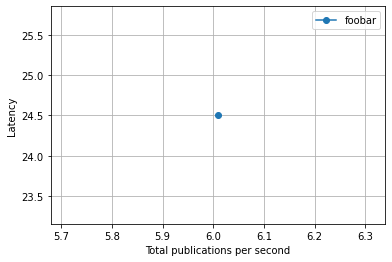

In [81]:
set_p(*testOut)
plt.xlabel("Total publications per second")
plt.ylabel("Latency")
fig.set_size_inches(6, 2.5)
plt.grid()
plt.legend()
fig.show()